# Homework 4

## FINM 35700 - Spring 2023

### UChicago Financial Mathematics

* Alex Popovici
* alex.popovici@uchicago.edu

This homework relies on multiple files (from previous weeks):

- the US government bonds symbology file `govt_symbology`, 
- the "on-the-run" treasuries data file `govt_on_the_run`,
- the corporate bonds symbology file `corp_symbology`,
- the cash bond market data file `market_prices_eod`,
- the CDS data file `cds_market_data_eod`. 
- the SOFR OIS Swap symbology file `sofr_swap_symbology`,
- the SOFR OIS Swap market data file `sofr_swaps_market_data_eod`.



In [64]:
import QuantLib as ql
import numpy as np
import pandas as pd
import datetime as dt
import os
import matplotlib.pyplot as plt
import random
from datetime import datetime
from scipy.optimize import fsolve

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Use static calculation/valuation date of 2023-04-14, matching data available in the market prices EOD file
calc_date = ql.Date(14, 4, 2023)
ql.Settings.instance().evaluationDate = calc_date

mydir = os.getcwd()

# Collection of useful helper functions from previous homeworks

In [65]:
def get_ql_date(date) -> ql.Date:
    """
    convert dt.date to ql.Date
    """
    if isinstance(date, dt.date):
        return ql.Date(date.day, date.month, date.year)
    elif isinstance(date, str):
        date = dt.datetime.strptime(date, "%Y-%m-%d").date()
        return ql.Date(date.day, date.month, date.year)
    else:
        raise ValueError(f"to_qldate, {type(date)}, {date}")


def create_schedule_from_symbology(details: dict):
    '''Create a QuantLib cashflow schedule from symbology details dictionary (usually one row of the symbology dataframe)
    '''
    # Create maturity from details['maturity']
    maturity = get_ql_date(details['maturity'])
    
    # Create acc_first from details['acc_first']
    acc_first = get_ql_date(details['acc_first'])
    
    # Create calendar for Corp and Govt asset classes
    calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)
    
    # define period from details['cpn_freq'] ... can be hard-coded to 2 = semi-annual frequency
    period = ql.Period(2)
    
    # business_day_convention
    business_day_convention = ql.Unadjusted
    
    # termination_date_convention
    termination_date_convention = ql.Unadjusted
    
    # date_generation
    date_generation=ql.DateGeneration.Backward
    
    # Create schedule using ql.MakeSchedule interface (with keyword arguments)
    schedule = ql.MakeSchedule(effectiveDate=acc_first,  # this may not be the same as the bond's start date
                            terminationDate=maturity,
                            tenor=period,
                            calendar=calendar,
                            convention=business_day_convention,
                            terminalDateConvention=termination_date_convention,
                            rule=date_generation,
                            endOfMonth=True,
                            firstDate=ql.Date(),
                            nextToLastDate=ql.Date())
    return schedule


def create_bond_from_symbology(details: dict):
    '''Create a US fixed rate bond object from symbology details dictionary (usually one row of the symbology dataframe)
    '''
    
     # Create day_count from details['dcc']
     # For US Treasuries use ql.ActualActual(ql.ActualActual.ISMA)
     # For US Corporates use ql.Thirty360(ql.Thirty360.USA)
    if details['dcc'] == '30/360':
        day_count = ql.Thirty360(ql.Thirty360.USA)
    elif details['dcc'] == 'ACT/ACT':
        day_count = ql.ActualActual(ql.ActualActual.ISMA)
    else:
        raise ValueError(f"unsupported day count, {type(details['dcc'])}, {details['dcc']}")
    
    # Create day_count from details['start_date']    
    issue_date = get_ql_date(details['start_date'])
    
    # Create days_settle from details['days_settle']
    days_settle = int(float(details['days_settle']))

    # Create days_settle from details['coupon']
    coupon = float(details['coupon'])/100.

    # Create cashflow schedule
    schedule = create_schedule_from_symbology(details)
    
    face_value = 100
    redemption = 100
    
    payment_convention = ql.Unadjusted
        
    # Create fixed rate bond object
    fixed_rate_bond = ql.FixedRateBond(
        days_settle,
        face_value,
        schedule,
        [coupon],
        day_count,
        payment_convention,
        redemption,
        issue_date)        

    return fixed_rate_bond


def get_bond_cashflows(bond: ql.FixedRateBond, calc_date=ql.Date):
    '''Returns all future cashflows as of calc_date, i.e. with payment dates > calc_date.
    '''    
    day_counter = bond.dayCounter()    
    
    x = [(cf.date(), day_counter.yearFraction(calc_date, cf.date()), cf.amount()) for cf in bond.cashflows()]
    cf_date, cf_yearFrac, cf_amount = zip(*x)
    cashflows_df = pd.DataFrame(data={'CashFlowDate': cf_date, 'CashFlowYearFrac': cf_yearFrac, 'CashFlowAmount': cf_amount})

    # filter for payment dates > calc_date
    cashflows_df = cashflows_df[cashflows_df.CashFlowYearFrac > 0]
    return cashflows_df


def calibrate_yield_curve_from_frame(
        calc_date: ql.Date,
        treasury_details: pd.DataFrame,
        price_quote_column: str):
    '''Create a calibrated yield curve from a details dataframe which includes bid/ask/mid price quotes.
    '''
    ql.Settings.instance().evaluationDate = calc_date

    # Sort dataframe by maturity
    sorted_details_frame = treasury_details.sort_values(by='maturity')    
    
    # For US Treasuries use ql.ActualActual(ql.ActualActual.ISMA)
    day_count = ql.ActualActual(ql.ActualActual.ISMA)

    bond_helpers = []
    
    for index, row in sorted_details_frame.iterrows():
        bond_object = create_bond_from_symbology(row)
        
        tsy_clean_price_quote = row[price_quote_column]
        tsy_clean_price_handle = ql.QuoteHandle(ql.SimpleQuote(tsy_clean_price_quote))
        
        bond_helper = ql.BondHelper(tsy_clean_price_handle, bond_object)
        bond_helpers.append(bond_helper)
        
    yield_curve = ql.PiecewiseLogCubicDiscount(calc_date, bond_helpers, day_count)
    yield_curve.enableExtrapolation()
    return yield_curve


def calibrate_sofr_curve_from_frame(
        calc_date: ql.Date,
        sofr_details: pd.DataFrame,
        rate_quote_column: str):
    '''Create a calibrated yield curve from a SOFR details dataframe which includes rate quotes.
    '''
    ql.Settings.instance().evaluationDate = calc_date

    # Sort dataframe by maturity
    sorted_details_frame = sofr_details.sort_values(by='tenor')    
    
    # settle_days
    settle_days = 2
    
    # For US SOFR OIS Swaps 
    day_count = ql.Actual360()

    # For US SOFR Swaps     
    calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)
    
    sofr_helpers = []
    
    for index, row in sorted_details_frame.iterrows():
        sofr_quote = row[rate_quote_column]
        tenor_in_years = row['tenor']
        sofr_tenor = ql.Period(tenor_in_years, ql.Years)
        
        # create sofr_rate_helper
        sofr_helper = ql.OISRateHelper(settle_days, sofr_tenor, ql.QuoteHandle(ql.SimpleQuote(sofr_quote/100)), ql.Sofr())
                        
        sofr_helpers.append(sofr_helper)
        
    sofr_yield_curve = ql.PiecewiseLinearZero(settle_days, calendar, sofr_helpers, day_count)
    sofr_yield_curve.enableExtrapolation()
    
    return sofr_yield_curve

# Calculate initial term and current time-to-maturity for each bond issue
def get_symbology(df, underlying=False):
    for index, row in df.iterrows():
        start_date = ql.Date(row['start_date'].day, row['start_date'].month, row['start_date'].year)
        maturity_date = ql.Date(row['maturity'].day, row['maturity'].month, row['maturity'].year)
        today_date = ql.Date(14,4,2023)
        calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)
        #set dcc as Actual/365.25
        dcc = ql.Actual36525()
        initial_term = dcc.yearFraction(start_date, maturity_date)
        current_time_to_maturity = dcc.yearFraction(today_date, maturity_date)
        df.at[index, 'term'] = initial_term
        df.at[index, 'TTM'] = current_time_to_maturity

    return df


# Problem 1: Pricing risky bonds in the hazard rate model
## This is building upon
- Homework 2 "Problem 2: US Treasury yield curve calibration (On-The-Runs)",
- Homework 3 "Problem 3: US SOFR swap curve calibration" and
- Homework 3 "Problem 4: CDS Hazard Rate calibration".

## a. Prepare the market data
### Load the symbology + market data dataframes. Calibrate the following curves as of 2023-04-14:
- the "on-the-run" US Treasury curve,
- the US SOFR curve and 
- the IBM CDS hazard rate curve (on the top of SOFR discount curve).


In [66]:
gov_otr = pd.read_excel(os.path.join(mydir, 'data', 'govt_on_the_run.xlsx'))
gov_otr = gov_otr[~gov_otr['ticker'].str.contains('B')]
gov_otr = gov_otr[~gov_otr['ticker'].str.contains('C')]
gov_otr.reset_index(drop=True, inplace=True)
gov_otr

,ticker,date,isin,figi
0,GT10 Govt,2023-04-14,US91282CGM73,BBG01DVKBC66
1,GT2 Govt,2023-04-14,US91282CGU99,BBG01G14BXX2
2,GT20 Govt,2023-04-14,US912810TQ13,BBG01F6N6GN1
3,GT3 Govt,2023-04-14,US91282CGV72,BBG01G5ZMM43
4,GT30 Govt,2023-04-14,US912810TN81,BBG01DVKBH56
5,GT5 Govt,2023-04-14,US91282CGT27,BBG01G14BW91
6,GT7 Govt,2023-04-14,US91282CGS44,BBG01G14BV75


In [67]:
market_data = pd.read_excel(os.path.join(mydir, 'data', 'market_prices_eod.xlsx'))
#rename mid_clean to mid
market_data.rename(columns={'mid_clean': 'mid'}, inplace=True)
#mid_yield is the average of bid_yield and ask_yield
market_data['mid_yield'] = (market_data['bid_yield'] + market_data['ask_yield'])/2
market_data.head()

,date,class,ticker,isin,figi,bid,ask,mid,mid_dirty,bid_yield,ask_yield,mid_yield
0,2023-04-14,Corp,DIS,US254687CZ75,BBG00QNKJ092,98.678,98.848,98.763,99.102,4.679,4.551,4.6150
1,2023-04-14,Corp,DIS,US254687DD54,BBG00QNKPCL5,98.454,98.821,98.637,98.668,4.361,4.203,4.2820
2,2023-04-14,Corp,DIS,US254687DK97,BBG00QNKGJP6,97.090,97.369,97.230,98.664,4.260,4.174,4.2170
3,2023-04-14,Corp,DIS,US254687DV52,BBG00QNKP8R8,115.163,115.984,115.574,116.174,4.624,4.529,4.5765
4,2023-04-14,Corp,DIS,US254687DZ66,BBG00QNKR4J4,112.939,113.586,113.262,115.380,4.742,4.674,4.7080


In [68]:
corp_symbology = pd.read_excel(os.path.join(mydir, 'data', 'corp_symbology.xlsx'))
#keep only cpn_type="FIXED" bonds
corp_symbology = corp_symbology[corp_symbology['cpn_type'] == 'FIXED']
#reset index
corp_symbology = corp_symbology.reset_index(drop=True)
corp_symbology.head()

,ticker,class,figi,isin,trace,und_bench_isin,security,name,type,coupon,...,cpn_freq,days_settle,start_date,cpn_first,acc_first,maturity,mty_typ,rank,country,currency
0,DIS,Corp,BBG00QNKJ092,US254687CZ75,DIS4921182,US91282CGU99,DIS 3.7 09/15/24,WALT DISNEY COMPANY/THE,GLOBAL,3.700,...,2,2,2019-11-22,2020-03-15,2019-09-15,2024-09-15,CALLABLE,Sr Unsecured,US,USD
1,DIS,Corp,BBG00QNKPCL5,US254687DD54,DIS4907444,US91282CGU99,DIS 3.7 10/15/25,WALT DISNEY COMPANY/THE,GLOBAL,3.700,...,2,2,2019-11-22,2020-04-15,2019-10-15,2025-10-15,CALLABLE,Sr Unsecured,US,USD
2,DIS,Corp,BBG00QNKGJP6,US254687DK97,DIS4907439,US91282CGR60,DIS 3 3/8 11/15/26,WALT DISNEY COMPANY/THE,GLOBAL,3.375,...,2,2,2019-11-22,2020-05-15,2019-11-15,2026-11-15,CALLABLE,Sr Unsecured,US,USD
3,DIS,Corp,BBG00QNKP8R8,US254687DV52,DIS4908605,US91282CGM73,DIS 6.55 03/15/33,WALT DISNEY COMPANY/THE,GLOBAL,6.550,...,2,2,2019-11-22,2020-03-15,2019-09-15,2033-03-15,AT MATURITY,Sr Unsecured,US,USD
4,DIS,Corp,BBG00QNKR4J4,US254687DZ66,DIS4908062,US91282CGM73,DIS 6.2 12/15/34,WALT DISNEY COMPANY/THE,GLOBAL,6.200,...,2,2,2019-11-22,2019-12-15,2019-06-15,2034-12-15,AT MATURITY,Sr Unsecured,US,USD


In [69]:
govt_symbology = pd.read_excel(os.path.join(mydir, 'data', 'govt_symbology.xlsx'))
#keep only cpn_type="FIXED" bonds
govt_symbology = govt_symbology[govt_symbology['cpn_type'] == 'FIXED']
#reset index
govt_symbology = govt_symbology.reset_index(drop=True)
govt_symbology.head()

,ticker,class,figi,isin,trace,security,name,type,coupon,cpn_type,dcc,cpn_freq,days_settle,start_date,cpn_first,acc_first,maturity,country,currency
0,T,Govt,BBG000DLJF04,US912810EQ77,TSRYS4493810,T 6 1/4 08/15/23,US TREASURY N/B,US GOVERNMENT,6.250,FIXED,ACT/ACT,2.0,1,1993-08-16,1994-02-15,1993-08-15,2023-08-15,US,USD
1,T,Govt,BBG000DKZWK9,US912810ES34,TSRYS4493811,T 7 1/2 11/15/24,US TREASURY N/B,US GOVERNMENT,7.500,FIXED,ACT/ACT,2.0,1,1994-08-15,1994-11-15,1994-05-15,2024-11-15,US,USD
2,T,Govt,BBG000DLBVY0,US912810ET17,TSRYS4493812,T 7 5/8 02/15/25,US TREASURY N/B,US GOVERNMENT,7.625,FIXED,ACT/ACT,2.0,1,1995-02-15,1995-08-15,1995-02-15,2025-02-15,US,USD
3,T,Govt,BBG000DQQNJ8,US912810EV62,TSRYS4493813,T 6 7/8 08/15/25,US TREASURY N/B,US GOVERNMENT,6.875,FIXED,ACT/ACT,2.0,1,1995-08-15,1996-02-15,1995-08-15,2025-08-15,US,USD
4,T,Govt,BBG000DPXMD0,US912810EW46,TSRYS4493814,T 6 02/15/26,US TREASURY N/B,US GOVERNMENT,6.000,FIXED,ACT/ACT,2.0,1,1996-02-15,1996-08-15,1996-02-15,2026-02-15,US,USD


In [70]:
govt_symb = get_symbology(govt_symbology)
corp_symb = get_symbology(corp_symbology)
symbology = pd.concat([govt_symb, corp_symb], ignore_index=True)

In [71]:
symbology_md = pd.merge(symbology, market_data, on='figi', how='inner')
symbology_md = symbology_md[[col for col in symbology_md.columns if not col.endswith('_y')]]
symbology_md.columns = [col.replace('_x', '') for col in symbology_md.columns]
symbology_md.head()

,ticker,class,figi,isin,trace,security,name,type,coupon,cpn_type,...,mty_typ,rank,date,bid,ask,mid,mid_dirty,bid_yield,ask_yield,mid_yield
0,T,Govt,BBG000DLJF04,US912810EQ77,TSRYS4493810,T 6 1/4 08/15/23,US TREASURY N/B,US GOVERNMENT,6.250,FIXED,...,NaN,NaN,2023-04-14,100.4375,100.8750,100.6563,101.7090,4.858,3.542,4.2000
1,T,Govt,BBG000DKZWK9,US912810ES34,TSRYS4493811,T 7 1/2 11/15/24,US TREASURY N/B,US GOVERNMENT,7.500,FIXED,...,NaN,NaN,2023-04-14,104.7695,105.2148,104.9922,108.1621,4.336,4.051,4.1935
2,T,Govt,BBG000DLBVY0,US912810ET17,TSRYS4493812,T 7 5/8 02/15/25,US TREASURY N/B,US GOVERNMENT,7.625,FIXED,...,NaN,NaN,2023-04-14,105.9258,106.3477,106.1367,107.4219,4.224,3.992,4.1080
3,T,Govt,BBG000DQQNJ8,US912810EV62,TSRYS4493813,T 6 7/8 08/15/25,US TREASURY N/B,US GOVERNMENT,6.875,FIXED,...,NaN,NaN,2023-04-14,106.2578,106.9297,106.5938,107.7520,4.032,3.740,3.8860
4,T,Govt,BBG000DPXMD0,US912810EW46,TSRYS4493814,T 6 02/15/26,US TREASURY N/B,US GOVERNMENT,6.000,FIXED,...,NaN,NaN,2023-04-14,105.4453,106.0547,105.7500,106.7617,3.946,3.725,3.8355


In [72]:
symbology_md_otr = symbology_md[symbology_md['isin'].isin(gov_otr['isin'])].reset_index(drop=True)
symbology_md_otr[['figi', 'date', 'bid', 'ask', 'mid', 'bid_yield', 'ask_yield', 'mid_yield', 'TTM', 'term']]
symbology_md_otr.rename(columns={'mid': 'mid_clean'}, inplace=True)

In [73]:
sofr_swaps_symbology = pd.read_excel(os.path.join(mydir,'data', 'sofr_swaps_symbology.xlsx'))
sofr_swaps_market_data_eod = pd.read_excel(os.path.join(mydir,'data', 'sofr_swaps_market_data_eod.xlsx'))
sofr_swaps_market_data_eod1 = sofr_swaps_market_data_eod.merge(sofr_swaps_symbology, left_on='symbol', right_on='figi', how='left')

In [74]:
sofr_swaps_market_data_eod2 = sofr_swaps_market_data_eod1[sofr_swaps_market_data_eod1.date == "2023-04-14"].reset_index(drop=True)
sofr_swaps_market_data_eod2 = sofr_swaps_market_data_eod2.rename(columns={'term':'tenor'})

#### Extracting ther CDS Spread for the given date (2023-04-14)

In [75]:
cds_market_data_eod = pd.read_excel(os.path.join(mydir,'data', 'cds_market_data_eod.xlsx'))
cds_market_data_eod1 = cds_market_data_eod.filter(regex='^par_spread_.*|date')
settle_days = 2
cds_market_data_eod2 = cds_market_data_eod1[cds_market_data_eod1.date == "2023-04-14"].reset_index(drop=True)
cds_market_data_eod2 = cds_market_data_eod2.values.tolist()
cds_market_data_eod2 = cds_market_data_eod2[0][1:]
cds_market_data_eod2 = np.array(cds_market_data_eod2)

In [76]:
# Use static calculation/valuation date of 2023-04-14, matching data available in the market prices EOD file
calc_date = ql.Date(14, 4, 2023)
ql.Settings.instance().evaluationDate = calc_date



# tsy_yield_curve calibration
treasury_otr_df = symbology_md_otr.copy()    # TODO: Follow Homework 2 Problem 2 and populate the US Treasury on-the-run symbology + market data frame !!!
tsy_yield_curve = calibrate_yield_curve_from_frame(calc_date, treasury_otr_df, 'mid_clean')
tsy_yield_curve_handle = ql.YieldTermStructureHandle(tsy_yield_curve)


# sofr_yield_curve calibration
sofr_df = sofr_swaps_market_data_eod2.copy()    # TODO: Follow Homework 3 Problem 3 and populate the SOFR symbology + market data frame !!!
sofr_yield_curve = calibrate_sofr_curve_from_frame(calc_date, sofr_df, 'mid_rate')
sofr_yield_curve_handle = ql.YieldTermStructureHandle(sofr_yield_curve)

CDS_recovery_rate = 0.4

# CDS standard tenors: 1Y, 2Y, 3Y, 5Y 7Y and 10Y
CDS_tenors = [ql.Period(y, ql.Years) for y in [1, 2, 3, 5, 7, 10]]
              
# CDS spreads for IBM as of calc_date = 2023-04-14
CDS_spreads = cds_market_data_eod2 * 10000

CDS_helpers = [ql.SpreadCdsHelper((CDS_spread / 10000.0), CDS_tenor, settle_days, ql.TARGET(),
                                  ql.Quarterly, ql.Following, ql.DateGeneration.TwentiethIMM, ql.Actual360(), CDS_recovery_rate, sofr_yield_curve_handle)
               
for (CDS_spread, CDS_tenor) in zip(CDS_spreads, CDS_tenors)]

# bootstrap hazard_rate_curve
hazard_rate_curve = ql.PiecewiseFlatHazardRate(calc_date, CDS_helpers, ql.Actual360())
hazard_rate_curve.enableExtrapolation()

# Display calibrated hazard rates and survival probabilities
hazard_list = [(hr[0].to_date(), hr[1] * 100, hazard_rate_curve.survivalProbability(hr[0])) for hr in hazard_rate_curve.nodes()]
grid_dates, hazard_rates, surv_probs = zip(*hazard_list)

hazard_rates_df = pd.DataFrame(data={'Date': grid_dates, 
                                     'HazardRate': hazard_rates,
                                     'SurvivalProb': surv_probs})


# hazard_rate_curve calibrated to IBM CDS par spreads
#hazard_rate_curve = []    # TODO: Follow Homework 3 Problem 4 and create the IBM hazard rate curve !!!
default_prob_curve_handle = ql.DefaultProbabilityTermStructureHandle(hazard_rate_curve)

## b. Create the IBM risky bond objects
### Identify the following 3 IBM fixed rate bonds in the symbology table and create the corresponding fixed rate bonds (3 bond objects).

- security = 'IBM 3.3 05/15/26' / figi = 'BBG00P3BLH05'
- security = 'IBM 3.3 01/27/27' / figi = 'BBG00FVNGFP3'
- security = 'IBM 3 1/2 05/15/29' / figi = 'BBG00P3BLH14'

Use the create_bond_from_symbology() function (discussed in from Homework 2, Problem 1b) to create the bonds objects.

List the bond cashflows using the get_bond_cashflows() function.

In [77]:
figi_list = ['BBG00P3BLH05', 'BBG00FVNGFP3','BBG00P3BLH14']
symbology_tres = symbology_md[symbology_md['figi'].isin(figi_list)].reset_index(drop=True)

In [78]:
symbology_tres

,ticker,class,figi,isin,trace,security,name,type,coupon,cpn_type,...,mty_typ,rank,date,bid,ask,mid,mid_dirty,bid_yield,ask_yield,mid_yield
0,IBM,Corp,BBG00FVNGFP3,US459200JR30,IBM4448403,IBM 3.3 01/27/27,IBM CORP,GLOBAL,3.3,FIXED,...,AT MATURITY,Sr Unsecured,2023-04-14,96.040,96.499,96.270,97.012,4.450,4.314,4.382
1,IBM,Corp,BBG00P3BLH05,US459200JZ55,IBM4832194,IBM 3.3 05/15/26,IBM CORP,GLOBAL,3.3,FIXED,...,AT MATURITY,Sr Unsecured,2023-04-14,96.597,96.977,96.787,98.190,4.496,4.360,4.428
2,IBM,Corp,BBG00P3BLH14,US459200KA85,IBM4832195,IBM 3 1/2 05/15/29,IBM CORP,GLOBAL,3.5,FIXED,...,AT MATURITY,Sr Unsecured,2023-04-14,93.741,94.203,93.972,95.460,4.696,4.604,4.650


In [79]:
#create bonds from the symbology_tres dataframe
bonds = []
for i in range(len(symbology_tres)):
    temp = create_bond_from_symbology(symbology_tres.iloc[i])
    bonds.append(temp)
    print(f'-------------------The bond is {symbology_tres.iloc[i]["figi"]}---------------')
    #print the cashflows of the bond
    print(get_bond_cashflows(temp, calc_date))

-------------------The bond is BBG00FVNGFP3---------------
          CashFlowDate  CashFlowYearFrac  CashFlowAmount
12     July 27th, 2023          0.286111            1.65
13  January 27th, 2024          0.786111            1.65
14     July 27th, 2024          1.286111            1.65
15  January 27th, 2025          1.786111            1.65
16     July 27th, 2025          2.286111            1.65
17  January 27th, 2026          2.786111            1.65
18     July 27th, 2026          3.286111            1.65
19  January 27th, 2027          3.786111            1.65
20  January 27th, 2027          3.786111          100.00
-------------------The bond is BBG00P3BLH05---------------
           CashFlowDate  CashFlowYearFrac  CashFlowAmount
7        May 15th, 2023          0.086111            1.65
8   November 15th, 2023          0.586111            1.65
9        May 15th, 2024          1.086111            1.65
10  November 15th, 2024          1.586111            1.65
11       May 15th, 202

## c. Compute CDS-implied (intrinsic) prices for the IBM fixd rate bonds

Price the 3 IBM bonds using the CDS-calibrated hazard rate curve for IBM (via RiskyBondEngine).

Print the clean prices and yields for the 3 test bonds. You can use the example code below.


In [80]:
def price_bond(bond, tsy_yield_curve_handle, default_prob_curve_handle, flat_recovery_rate):
    fixed_rate_bond = bond #ql.FixedRateBond()    # TODO: Pick one of the 3 IBM test bonds !!!

    # Risky bond engine uses the calibrated CDS hazard rate curve for pricing credit default risk 
    risky_bond_engine = ql.RiskyBondEngine(default_prob_curve_handle, flat_recovery_rate, tsy_yield_curve_handle)

    fixed_rate_bond.setPricingEngine(risky_bond_engine)

    corpBondModelPrice = fixed_rate_bond.cleanPrice()

    corpBondModelYield = fixed_rate_bond.bondYield(corpBondModelPrice, ql.Thirty360(ql.Thirty360.USA), ql.Compounded, ql.Semiannual) * 100

    print('corpBondCleanPrice', corpBondModelPrice)
    print('corpBondYield', corpBondModelYield)
    return corpBondModelPrice, corpBondModelYield

In [81]:
flat_recovery_rate = 0.40
for i,bond in enumerate(bonds):
    print(f'-------------------The bond is {symbology_tres.iloc[i]["figi"]}---------------')
    a,b = price_bond(bond, tsy_yield_curve_handle, default_prob_curve_handle, flat_recovery_rate)
    #save the price and yield of the bond as a new column in the symbology_tres dataframe
    symbology_tres.loc[i,'CDS_imp_price'] = a
    symbology_tres.loc[i,'CDS_imp_yield'] = b

-------------------The bond is BBG00FVNGFP3---------------
corpBondCleanPrice 96.9100750890096
corpBondYield 4.192307233810425
-------------------The bond is BBG00P3BLH05---------------
corpBondCleanPrice 97.49397074949623
corpBondYield 4.176120710372926
-------------------The bond is BBG00P3BLH14---------------
corpBondCleanPrice 96.2240136493928
corpBondYield 4.21048707980487


## d. Compute the "intrinsic" vs market price basis for the IBM bonds

Load the market clean prices and yields (mid quotes) from the market quotes dataframe as of 2023-04-14. Compute the basis between the "CDS-implied intrinsic" vs market values. 

- BasisInPrice = corpBondModelPrice - corpBondMarketPrice
- BasisInYield = corpBondModelYield - corpBondMarketYield


Are the CDS intrinsic prices lower or higher than the bond prices observed on the market? What factors could explain the basis?


In [82]:
symbology_tres['basis_in_price'] = symbology_tres['CDS_imp_price'] - symbology_tres['mid']
symbology_tres['basis_in_yield'] = symbology_tres['CDS_imp_yield'] - symbology_tres['mid_yield']
symbology_tres[['figi','mid','mid_yield','CDS_imp_price','CDS_imp_yield','basis_in_price','basis_in_yield']]

,figi,mid,mid_yield,CDS_imp_price,CDS_imp_yield,basis_in_price,basis_in_yield
0,BBG00FVNGFP3,96.270,4.382,96.910075,4.192307,0.640075,-0.189693
1,BBG00P3BLH05,96.787,4.428,97.493971,4.176121,0.706971,-0.251879
2,BBG00P3BLH14,93.972,4.650,96.224014,4.210487,2.252014,-0.439513


>The CDS implied prices (CDS_imp_price) are higher than the bond prices observed in the market (mid)
>
>Liquidity: If the bond is less liquid, it may trade at a discount to its theoretical price, creating a positive basis. A less liquid bond has fewer buyers and sellers, which can lead to larger bid-ask spreads and thus a lower market price.
>
>Recovery Rate Assumptions: The CDS implied price is based on an assumed recovery rate in the event of a default. If the market perceives the recovery rate to be lower than this assumed rate, the bond will trade at a discount, creating a positive basis.
>
>Counterparty Risk: The CDS price might reflect the risk that the counterparty won't fulfill their obligation in the event of a default. This risk is not present in the bond price.

# Problem 2: Compute scenario sensitivities for risky bonds
## a. Compute scenario IR01s for the 3 IBM bonds
Use the 3 IBM test bonds defined in Problem 1. 

Compute the scenario IR01 and Durations using a -1bp interest rate shock, as described in Section 6. "Market Data Scenarios" in the QuantLib introductory notebook.

Remember that DV01 = Dirty_Price * Duration.

In [83]:
def scenario_sensitivities(bond,details,tsy_yield_curve_handle,default_prob_curve_handle,flat_recovery_rate, bump=0.0001):
    """This function calculates the IR01 duration of a 
    bond given a yield curve and a bump value"""
    
    interest_rate_bump = ql.SimpleQuote(0.0)
    tsy_yield_curve_handle = ql.YieldTermStructureHandle(ql.ZeroSpreadedTermStructure(tsy_yield_curve_handle, ql.QuoteHandle(interest_rate_bump)))
    fixed_rate_bond = bond
    
    risky_bond_engine = ql.RiskyBondEngine(default_prob_curve_handle, flat_recovery_rate, tsy_yield_curve_handle)

    fixed_rate_bond.setPricingEngine(risky_bond_engine)
    
    price_dirty = fixed_rate_bond.dirtyPrice()
    
    base = fixed_rate_bond.NPV()
    
    # Bump interest rate by +1bps (parallel shift)
    interest_rate_bump.setValue(bump)
    price_up_1bp = fixed_rate_bond.NPV()
    
    # Bump interest rate by -1bps (parallel shift)
    interest_rate_bump.setValue(-bump)
    price_down_1bp = fixed_rate_bond.NPV()
    
    # Reset interest rate to base value
    interest_rate_bump.setValue(0.0)
    
    IR01 = (price_down_1bp - base) * 100
    
    duration = IR01 / price_dirty * 100
    
    
    convexity = (price_down_1bp + price_up_1bp - 2 * base) * 1000000 / price_dirty * 100
    
    return IR01, duration, convexity

In [84]:
ir01_1, duration_1, _ =scenario_sensitivities(bonds[0],symbology_tres.iloc[0],tsy_yield_curve_handle,default_prob_curve_handle,flat_recovery_rate, bump=0.0001)
ir01_2, duration_2, _ =scenario_sensitivities(bonds[1],symbology_tres.iloc[1],tsy_yield_curve_handle,default_prob_curve_handle,flat_recovery_rate, bump=0.0001)
ir01_3, duration_3, _ =scenario_sensitivities(bonds[2],symbology_tres.iloc[2],tsy_yield_curve_handle,default_prob_curve_handle,flat_recovery_rate, bump=0.0001)

In [85]:
print(f'The IR01 of {symbology_tres.iloc[0]["figi"]} is {ir01_1} and the duration is {duration_1}')
print(f'The IR01 of {symbology_tres.iloc[1]["figi"]} is {ir01_2} and the duration is {duration_2}')
print(f'The IR01 of {symbology_tres.iloc[2]["figi"]} is {ir01_3} and the duration is {duration_3}')

The IR01 of BBG00FVNGFP3 is 3.5026677105548742 and the duration is 3.586866713307066
The IR01 of BBG00P3BLH05 is 2.8740782991647507 and the duration is 2.9061484979021768
The IR01 of BBG00P3BLH14 is 5.263161791404514 and the duration is 5.386429495186946


## b. Compute scenario Convexities for the 3 IBM bonds
Use the 3 IBM test bonds defined in Problem 1. 

Compute the scenario Convexities using the +/-1bp interest rate shocks, as described in Section 6. "Market Data Scenarios" in the QuantLib introductory notebook.


In [86]:
_,_,convexity_1 =scenario_sensitivities(bonds[0],symbology_tres.iloc[0],tsy_yield_curve_handle,default_prob_curve_handle,flat_recovery_rate, bump=0.0001)
_,_,convexity_2 =scenario_sensitivities(bonds[1],symbology_tres.iloc[1],tsy_yield_curve_handle,default_prob_curve_handle,flat_recovery_rate, bump=0.0001)
_,_,convexity_3 =scenario_sensitivities(bonds[2],symbology_tres.iloc[2],tsy_yield_curve_handle,default_prob_curve_handle,flat_recovery_rate, bump=0.0001)

In [87]:
print(f'The convexity of {symbology_tres.iloc[0]["figi"]} is {convexity_1}')
print(f'The convexity of {symbology_tres.iloc[1]["figi"]} is {convexity_2}')
print(f'The convexity of {symbology_tres.iloc[2]["figi"]} is {convexity_3}')

The convexity of BBG00FVNGFP3 is 13.435018464313403
The convexity of BBG00P3BLH05 is 8.798492451527844
The convexity of BBG00P3BLH14 is 31.43580958818022


## c. Compute scenario HR01s (hazard rate sensitivity) and CS01s (credit spread sensitivity) for the 3 IBM bonds
Use the 3 IBM test bonds defined in Problem 1. 

Apply a -1bp (parallel shift) scenario to the IBM CDS Par Spread quotes and calibrate the scenario hazard rate curve. 

Create a new scenario RiskyBondEngine, using the scenario hazard rate curve.

Reprice the risky bonds on the scenario RiskyBondEngine (using the bumped hazard rate curve) to obtain the -1bp scenario HR01 (hazard rate sensitivity).

The credit spread sensitivity CS01 is defined as CS01 = (ScenarioPrice - BasePrice) / (ScenarioYield - BasePYield) * 100.

Compute the scenario bond yields and the scenario CS01s for the 3 bonds.


In [88]:
def calibrate_hazard_curve(cds_market_data,sofr_yield_curve_handle,rec_rate=0.4, cds_bump = 0.0001):
    CDS_recovery_rate = rec_rate

    # CDS standard tenors: 1Y, 2Y, 3Y, 5Y 7Y and 10Y
    CDS_tenors = [ql.Period(y, ql.Years) for y in [1, 2, 3, 5, 7, 10]]
                
    # CDS spreads for IBM as of calc_date = 2023-04-28
    cds_market_data_bumped = cds_market_data + cds_bump
    CDS_spreads = cds_market_data_bumped * 10000

    CDS_helpers = [ql.SpreadCdsHelper((CDS_spread / 10000.0), CDS_tenor, settle_days, ql.TARGET(),
                                    ql.Quarterly, ql.Following, ql.DateGeneration.TwentiethIMM, ql.Actual360(), CDS_recovery_rate, sofr_yield_curve_handle)
                
    for (CDS_spread, CDS_tenor) in zip(CDS_spreads, CDS_tenors)]

    # bootstrap hazard_rate_curve
    hazard_rate_curve = ql.PiecewiseFlatHazardRate(calc_date, CDS_helpers, ql.Actual360())
    hazard_rate_curve.enableExtrapolation()

    # hazard_rate_curve calibrated to IBM CDS par spreads
    default_prob_curve_handle = ql.DefaultProbabilityTermStructureHandle(hazard_rate_curve)
    
    return hazard_rate_curve, default_prob_curve_handle

In [89]:
def scenario_sensitivities_hazard(bond,details,tsy_yield_curve_handle,cds_market_data, flat_recovery_rate=0.4, bump=0.0001):
    """This function calculates the HR01 and CS01 of a
    bond given a yield curve and a bump value"""
    fixed_rate_bond = bond
    
    hazard_rate_curve, default_prob_curve_handle = calibrate_hazard_curve(cds_market_data,sofr_yield_curve_handle,rec_rate=flat_recovery_rate, cds_bump = 0.0)
    risky_bond_engine = ql.RiskyBondEngine(default_prob_curve_handle, flat_recovery_rate, tsy_yield_curve_handle)
    fixed_rate_bond.setPricingEngine(risky_bond_engine)
    
    base_price = fixed_rate_bond.cleanPrice()
    base_NPV = fixed_rate_bond.NPV()
    base_yield = fixed_rate_bond.bondYield(base_price, ql.Thirty360(ql.Thirty360.USA), ql.Compounded, ql.Semiannual) *100
    
    # -1bp and recalibrate hazard curve and risk engine
    hazard_rate_curve_1bp, default_prob_curve_handle_1bp = calibrate_hazard_curve(cds_market_data,sofr_yield_curve_handle,rec_rate=flat_recovery_rate, cds_bump = -bump)
    risky_bond_engine_1bp = ql.RiskyBondEngine(default_prob_curve_handle_1bp, flat_recovery_rate, tsy_yield_curve_handle)
    fixed_rate_bond.setPricingEngine(risky_bond_engine_1bp)
    
    price_down_1bp = fixed_rate_bond.cleanPrice()
    yield_down_1bp = fixed_rate_bond.bondYield(price_down_1bp, ql.Thirty360(ql.Thirty360.USA), ql.Compounded, ql.Semiannual) *100
    
    
    #credit spread sensitivity CS01 is defined as CS01 = (ScenarioPrice - BasePrice) / (ScenarioYield - BasePYield) * 100
    CS01 = (price_down_1bp - base_price) / (yield_down_1bp - base_yield) *100
    
    HR01 = CS01 * (1-flat_recovery_rate)
    
    return HR01, CS01, yield_down_1bp, base_NPV
    
    

In [90]:
HR01_1, CS01_1, scn_yield_1,_ = scenario_sensitivities_hazard(bonds[0],symbology_tres.iloc[0],tsy_yield_curve_handle,cds_market_data_eod2,flat_recovery_rate=0.4, bump=0.0001)
HR01_2, CS01_2, scn_yield_2,_ = scenario_sensitivities_hazard(bonds[1],symbology_tres.iloc[1],tsy_yield_curve_handle,cds_market_data_eod2,flat_recovery_rate=0.4, bump=0.0001)
HR01_3, CS01_3, scn_yield_3,_ = scenario_sensitivities_hazard(bonds[2],symbology_tres.iloc[2],tsy_yield_curve_handle,cds_market_data_eod2,flat_recovery_rate=0.4, bump=0.0001)

In [91]:
print(f'The HR01 of {symbology_tres.iloc[0]["figi"]} is {HR01_1} and the CS01 is {CS01_1} and the yield is {scn_yield_1}')
print(f'The HR01 of {symbology_tres.iloc[1]["figi"]} is {HR01_2} and the CS01 is {CS01_2} and the yield is {scn_yield_2}')
print(f'The HR01 of {symbology_tres.iloc[2]["figi"]} is {HR01_3} and the CS01 is {CS01_3} and the yield is {scn_yield_3}')

The HR01 of BBG00FVNGFP3 is -203.80213858349694 and the CS01 is -339.6702309724949 and the yield is 4.1820096492767345
The HR01 of BBG00P3BLH05 is -168.95043335484328 and the CS01 is -281.5840555914055 and the yield is 4.165805768966675
The HR01 of BBG00P3BLH14 is -311.7815041089997 and the CS01 is -519.6358401816661 and the yield is 4.200223207473755


In [92]:
from prettytable import PrettyTable
table = PrettyTable()
table.field_names = ["Bond", "Convexity", "HR01", "CS01", "Scn Yield"]
table.add_row([symbology_tres.iloc[0]["figi"], round(convexity_1,4), round(HR01_1,4), round(CS01_1,4), round(scn_yield_1,4)])
table.add_row([symbology_tres.iloc[1]["figi"], round(convexity_2,4), round(HR01_2,4), round(CS01_2,4), round(scn_yield_2,4)])
table.add_row([symbology_tres.iloc[2]["figi"], round(convexity_3,4), round(HR01_3,4), round(CS01_3,4), round(scn_yield_3,4)])
print(table)

+--------------+-----------+-----------+-----------+-----------+
|     Bond     | Convexity |    HR01   |    CS01   | Scn Yield |
+--------------+-----------+-----------+-----------+-----------+
| BBG00FVNGFP3 |   13.435  | -203.8021 | -339.6702 |   4.182   |
| BBG00P3BLH05 |   8.7985  | -168.9504 | -281.5841 |   4.1658  |
| BBG00P3BLH14 |  31.4358  | -311.7815 | -519.6358 |   4.2002  |
+--------------+-----------+-----------+-----------+-----------+


## d. Compute scenario Rec01 (recovery rate sensitivity) for the 3 IBM bonds
Use the 3 IBM test bonds defined in Problem 1. 

Apply a +1% scenario bump to the IBM recovery rate (flat_recovery_rate parameter will move from 40% to 41%).

Create a new scenario RiskyBondEngine, using the scenario new recovery rate.

Reprice the risky bonds on the scenario RiskyBondEngine (using the bumped recovery rate) to obtain the +1% scenario REC01 (recovery rate sensitivity).


In [93]:
_,_,_,base_price_1 = scenario_sensitivities_hazard(bonds[0],symbology_tres.iloc[0],tsy_yield_curve_handle,cds_market_data_eod2,flat_recovery_rate=0.4, bump=0.0001)
_,_,_,bumped_price_1 = scenario_sensitivities_hazard(bonds[0],symbology_tres.iloc[0],tsy_yield_curve_handle,cds_market_data_eod2,flat_recovery_rate=0.41, bump=0.0001)
print(f'The price of {symbology_tres.iloc[0]["figi"]} is {base_price_1} and the price with a 1bp higher recovery rate is {bumped_price_1}')
print(f'The REC01 of {symbology_tres.iloc[0]["figi"]} is {(bumped_price_1 - base_price_1)*100}')

The price of BBG00FVNGFP3 is 97.60833863824169 and the price with a 1bp higher recovery rate is 97.60837286931627
The REC01 of BBG00FVNGFP3 is 0.0034231074579338383


In [94]:
_,_,_,base_price_2 = scenario_sensitivities_hazard(bonds[1],symbology_tres.iloc[1],tsy_yield_curve_handle,cds_market_data_eod2,flat_recovery_rate=0.4, bump=0.0001)
_,_,_,bumped_price_2 = scenario_sensitivities_hazard(bonds[1],symbology_tres.iloc[1],tsy_yield_curve_handle,cds_market_data_eod2,flat_recovery_rate=0.41, bump=0.0001)
print(f'The price of {symbology_tres.iloc[1]["figi"]} is {base_price_2} and the price with a 1bp higher recovery rate is {bumped_price_2}')
print(f'The REC01 of {symbology_tres.iloc[1]["figi"]} is {(bumped_price_2 - base_price_2)*100}')

The price of BBG00P3BLH05 is 98.8516708161054 and the price with a 1bp higher recovery rate is 98.85163243605655
The REC01 of BBG00P3BLH05 is -0.0038380048849262494


In [95]:
_,_,_,base_price_3 = scenario_sensitivities_hazard(bonds[2],symbology_tres.iloc[2],tsy_yield_curve_handle,cds_market_data_eod2,flat_recovery_rate=0.4, bump=0.0001)
_,_,_,bumped_price_3 = scenario_sensitivities_hazard(bonds[2],symbology_tres.iloc[2],tsy_yield_curve_handle,cds_market_data_eod2,flat_recovery_rate=0.41, bump=0.0001)
print(f'The price of {symbology_tres.iloc[2]["figi"]} is {base_price_3} and the price with a 1bp higher recovery rate is {bumped_price_3}')
print(f'The REC01 of {symbology_tres.iloc[2]["figi"]} is {(bumped_price_3 - base_price_3)*100}')

The price of BBG00P3BLH14 is 97.66725049955707 and the price with a 1bp higher recovery rate is 97.6673315139673
The REC01 of BBG00P3BLH14 is 0.008101441022745348


# Problem 3: Nelson-Siegel model for smooth hazard rate curves
## Follow Lecture 4, Section 1 "Parametric Hazard Rate Models"
## Follow Section "13. Smooth parametric yield and hazard rate curves: the Nelson-Siegel model" in the QuantLib Intro V3 notebook
## You can also take a look at Dr. Mark Hendricks Fixed Income notebooks describing the Nelson-Siegel model calibration on US Treasuries (GitHub repo link posted in Canvas).

## a. Prepare the market data as of 2023-04-14
Load the symbology + market data dataframes for all Verizon fixed rate bonds (ticker = 'VZ'). 

Calibrate the "on-the-run" US Treasury curve, which will be used as discount factor curve.


In [96]:
symbology_md_vzn = symbology_md[symbology_md['ticker'] == 'VZ'].reset_index(drop=True)
# filter out mty_typ == "CALLABLE"
symbology_md_vzn = symbology_md_vzn[symbology_md_vzn['mty_typ'] != "CALLABLE"].sort_values(by='TTM').reset_index(drop=True)
symbology_md_vzn

,ticker,class,figi,isin,trace,security,name,type,coupon,cpn_type,...,mty_typ,rank,date,bid,ask,mid,mid_dirty,bid_yield,ask_yield,mid_yield
0,VZ,Corp,BBG00ZLKTDJ4,US92343VGF58,VZ5148416,VZ 0 3/4 03/22/24,VERIZON COMMUNICATIONS,GLOBAL,0.750,FIXED,...,AT MATURITY,Sr Unsecured,2023-04-14,95.975,96.327,96.151,96.205,5.251,4.846,5.0485
1,VZ,Corp,BBG00JKZK9K4,US92343VEN01,VZ4581325,VZ 3.376 02/15/25,VERIZON COMMUNICATIONS,GLOBAL,3.376,FIXED,...,AT MATURITY,Sr Unsecured,2023-04-14,97.932,98.164,98.048,98.639,4.567,4.432,4.4995
2,VZ,Corp,BBG00DGYP877,US92343VDD38,VZ4388863,VZ 2 5/8 08/15/26,VERIZON COMMUNICATIONS,GLOBAL,2.625,FIXED,...,AT MATURITY,Sr Unsecured,2023-04-14,94.335,94.691,94.513,94.972,4.477,4.356,4.4165
3,VZ,Corp,BBG00G6QW2B8,US92343VDY74,VZ4466757,VZ 4 1/8 03/16/27,VERIZON COMMUNICATIONS,GLOBAL,4.125,FIXED,...,AT MATURITY,Sr Unsecured,2023-04-14,98.928,99.216,99.072,99.439,4.426,4.344,4.3850
4,VZ,Corp,BBG00M1BQWX0,US92343VER15,VZ4719974,VZ 4.329 09/21/28,VERIZON COMMUNICATIONS,GLOBAL,4.329,FIXED,...,AT MATURITY,Sr Unsecured,2023-04-14,98.655,99.025,98.840,99.165,4.611,4.533,4.5720
5,VZ,Corp,BBG00003TCX8,US92344GAM87,VZ.MT,VZ 7 3/4 12/01/30,VERIZON COMMUNICATIONS,US DOMESTIC,7.750,FIXED,...,AT MATURITY,Sr Unsecured,2023-04-14,117.238,117.974,117.606,120.555,5.000,4.894,4.9470
6,VZ,Corp,BBG00HC11V79,US92343VEA89,VZ4526725,VZ 4 1/2 08/10/33,VERIZON COMMUNICATIONS,GLOBAL,4.500,FIXED,...,AT MATURITY,Sr Unsecured,2023-04-14,96.081,96.791,96.436,97.286,4.990,4.899,4.9445
7,VZ,Corp,BBG00580D503,US92343VBS25,VZ4050438,VZ 6.4 09/15/33,VERIZON COMMUNICATIONS,GLOBAL,6.400,FIXED,...,AT MATURITY,Sr Unsecured,2023-04-14,110.109,110.490,110.300,110.886,5.133,5.089,5.1110
8,VZ,Corp,BBG009PNV1G8,US92343VCV45,VZ4213375,VZ 4.272 01/15/36,VERIZON COMMUNICATIONS,GLOBAL,4.272,FIXED,...,AT MATURITY,Sr Unsecured,2023-04-14,92.374,93.362,92.868,93.972,5.092,4.981,5.0365
9,VZ,Corp,BBG00G6QW5Q5,US92343VDU52,VZ4466640,VZ 5 1/4 03/16/37,VERIZON COMMUNICATIONS,GLOBAL,5.250,FIXED,...,AT MATURITY,Sr Unsecured,2023-04-14,101.287,102.168,101.728,102.195,5.119,5.031,5.0750


In [97]:
tsy_yield_curve_handle

<QuantLib.QuantLib.YieldTermStructureHandle; proxy of <Swig Object of type 'Handle< YieldTermStructure > *' at 0x2959dc780> >

In [98]:
def nelson_siegel(params, maturity):
    ''' params = (theta1, theta2, theta3, lambda)'''    
    slope_1 = (1 - np.exp(-maturity/params[3]))/(maturity/params[3])

    if(np.isnan(slope_1)):
        slope_1 = 1

    curvature_1 = slope_1 - np.exp(-maturity/params[3])

    total_value = params[0] + params[1] * slope_1 + params[2] * curvature_1
    
    return total_value

def nelson_siegel_extended(params, maturity):
    
    slope_1 = (1 - np.exp(-maturity/params[3]))/(maturity/params[3])

    if(np.isnan(slope_1)):
        slope_1 = 1

    curvature_1 = slope_1 - np.exp(-maturity/params[3])

    total_value = params[0] + params[1] * slope_1 + params[2] * curvature_1
    
    if(params[5] != 0):
        slope_2 = (1 - np.exp(-maturity/params[5]))/(maturity/params[5])

        if(np.isnan(slope_2)):
            slope_2 = 1

        curvature_2 = slope_2 - np.exp(-maturity/params[5])

        total_value = total_value + params[4] * curvature_2
        
    
    return total_value

## b. Create the Nelson-Siegel curve shape (4 parameters) and compute the corresponding SSE function.
For a given set of parameters, write a function to compute the SSE "Sum of Squared Errors" penalty function in price space (defined as sum of squared differences between model and market prices for all Verizon fixed-rate bonds).


For each bond, compute the bond durations, using Section "9. Analytical Duration" in the QuantLib introductory notebook as a template.

Use 1/Duration as SSE weights. You can ignore the liquidity adjuster for the purpose of this exercise.

In [99]:
def SSE(params, bond_data, flat_rate_value):
    flat_rate = ql.SimpleQuote(flat_rate_value)
    sse = 0.0

    for index, row in bond_data.iterrows():
        fixed_rate_bond = create_bond_from_symbology(row)

        # Compute bond duration
        coupon_freq = ql.Semiannual
        flat_int_rate = ql.InterestRate(flat_rate.value(), fixed_rate_bond.dayCounter(), ql.Compounded, coupon_freq)
        bond_duration = ql.BondFunctions.duration(fixed_rate_bond, flat_int_rate)

        # Compute model price. maturtiy is the TTM
        maturity = row['TTM']
        model_price = nelson_siegel(params, maturity) * 100

        # Compute market price
        market_price = row['mid']

        # Compute weighted squared error
        weight = 1 / bond_duration
        squared_error = weight * (model_price - market_price)**2

        sse += squared_error

    return sse

#### Sample calculation

In [100]:
SSE([0.03,-0.01,-0.001,2],symbology_md_vzn,0.05)

37841.16627866493

## c. Calibrate the Nelson-Siegel model parameters to obtain the smooth Verizon credit curve.

Minimize the SSE (pricing error) function to obtain the optimal/calibrated Nelson-Siegel parameter vector. 

Create the calibrated/smooth credit curve corresponding to the optimal model parameters.

In [101]:
# Minimize the SSE (pricing error) function to obtain the optimal/calibrated Nelson-Siegel parameter vector.
theta1, theta2, theta3, lambda_ = 0.1, 0.1, 0.1, 0.1
params = [theta1, theta2, theta3, lambda_]
flat_rate_value = 0.04

from scipy.optimize import minimize
result = minimize(SSE, params, args=(symbology_md_vzn, flat_rate_value), method='Nelder-Mead', tol=1e-6)

In [102]:
# Print the optimal parameter vector
print(result.x)

[ 1.00469061 -0.51341327  0.0126438   0.0833198 ]


In [103]:
# Show the SSE for the optimal parameter vector
print(result.fun)

144.3669631527398


#### Create the calibrated/smooth credit curve corresponding to the optimal model parameters.

In [104]:
# nelson_siegel_params = [theta1, theta2, theta3, lambda] = [long term level, short - long slope, curvature, lambda]
nelson_siegel_params = result.x

nelson_siegel_surv_prob_dates = [calc_date+ql.Period(i,ql.Years) for i in range(0,31)]
nelson_siegel_average_hazard_rates = [nelson_siegel(nelson_siegel_params, T) for T in range(31)]
nelson_siegel_surv_prob_levels = [np.exp(-T * nelson_siegel_average_hazard_rates[T]) for T in range(31)]

# nelson_siegel_surv_prob_curve
nelson_siegel_credit_curve = ql.SurvivalProbabilityCurve(nelson_siegel_surv_prob_dates, nelson_siegel_surv_prob_levels, ql.Actual360(), ql.TARGET())
nelson_siegel_credit_curve.enableExtrapolation()
nelson_siegel_credit_curve_handle = ql.DefaultProbabilityTermStructureHandle(nelson_siegel_credit_curve)


               Dates  Average Hazard Rates  Survival Probs
0   April 14th, 2023              0.491277    1.000000e+00
1   April 14th, 2024              0.962967    3.817586e-01
2   April 14th, 2025              0.983829    1.397840e-01
3   April 14th, 2026              0.990783    5.118300e-02
4   April 14th, 2027              0.994260    1.874106e-02
5   April 14th, 2028              0.996346    6.862187e-03
6   April 14th, 2029              0.997737    2.512644e-03
7   April 14th, 2030              0.998730    9.200245e-04
8   April 14th, 2031              0.999475    3.368742e-04
9   April 14th, 2032              1.000055    1.233492e-04
10  April 14th, 2033              1.000518    4.516527e-05
11  April 14th, 2034              1.000898    1.653762e-05
12  April 14th, 2035              1.001214    6.055381e-06
13  April 14th, 2036              1.001481    2.217225e-06
14  April 14th, 2037              1.001710    8.118546e-07
15  April 14th, 2038              1.001909    2.972670e-

Text(0.5, 0, 'Maturity')

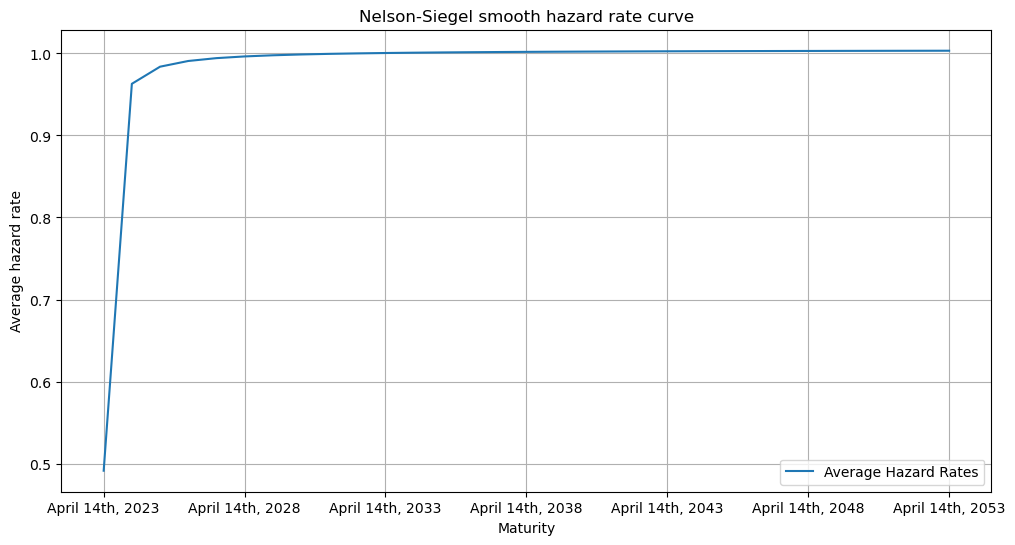

In [105]:
nelson_siegel_surv_prob_df = pd.DataFrame(data={'Dates': nelson_siegel_surv_prob_dates,
                                          'Average Hazard Rates': nelson_siegel_average_hazard_rates,
                                          'Survival Probs': nelson_siegel_surv_prob_levels})
print(nelson_siegel_surv_prob_df)

plot = nelson_siegel_surv_prob_df.plot(x='Dates', y=['Average Hazard Rates'], grid=True, style='-', title='Nelson-Siegel smooth hazard rate curve', figsize=(12,6))
plot.set_ylabel('Average hazard rate')
plot.set_xlabel('Maturity')

## d. Compute smooth model prices, yields and "edges"

Price all Verizon bonds on the calibrated credit curve and compute the corresponding yields.

Plot the model vs market yields (Y-axis) by time to maturity (X-axis).

Plot the edges in yield space (Y-axis) by time to maturity (X-axis).

In [106]:
#Price all Verizon bonds on the calibrated credit curve and compute the corresponding yields
bond_recovery_rate = 0.4
nelson_siegel_risky_bond_engine = ql.RiskyBondEngine(nelson_siegel_credit_curve_handle, bond_recovery_rate, tsy_yield_curve_handle)

for i, bond in symbology_md_vzn.iterrows():
    fixed_rate_bond = create_bond_from_symbology(bond)
    fixed_rate_bond.setPricingEngine(nelson_siegel_risky_bond_engine)
    #add ns_price to symbology_md_vzn
    symbology_md_vzn.loc[i,'ns_price'] = fixed_rate_bond.cleanPrice()
    #add ns_yield to symbology_md_vzn
    symbology_md_vzn.loc[i,'ns_yield'] = fixed_rate_bond.bondYield(fixed_rate_bond.cleanPrice(), fixed_rate_bond.dayCounter(), ql.Compounded, ql.Semiannual) * 50


Text(0.5, 0, 'TTM')

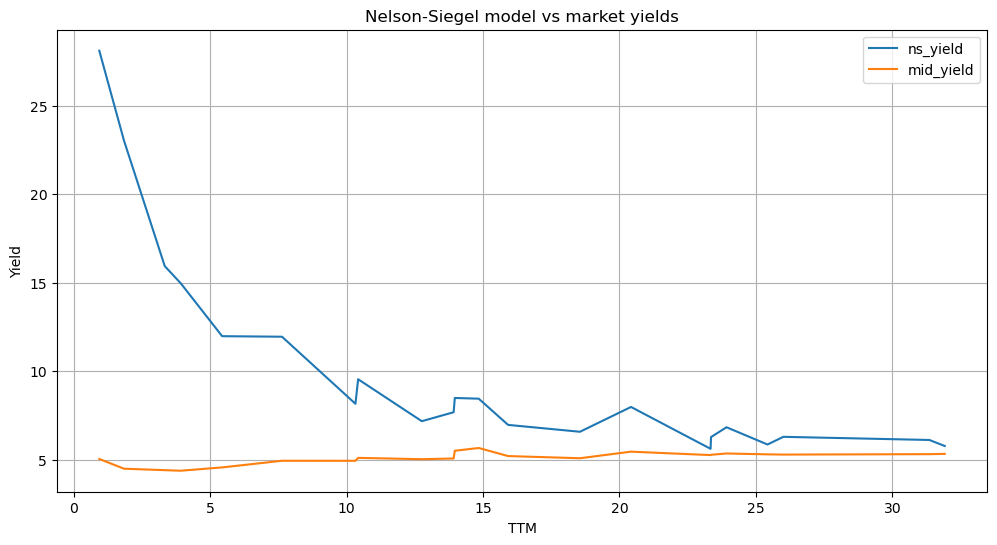

In [107]:
#Plot the model ("ns_yield") vs market yields ("mid_yield") (Y-axis) by time to maturity ("TTM") (X-axis).
plot = symbology_md_vzn.plot(x='TTM', y=['ns_yield', 'mid_yield'], grid=True, style='-', title='Nelson-Siegel model vs market yields', figsize=(12,6))
plot.set_ylabel('Yield')
plot.set_xlabel('TTM')

# Problem 4: Pricing bonds in the Merton Structural Credit Model
## Follow Lecture 4, Section 2 "Structural Credit Default Models"

## a. Company balance sheet metrics & fair value of equity
- Assets of $125 MM
- Liabilities of $100 MM face value, consisting of one zero coupon bond.
- Bond maturity is at T = 5 years
- Asset volatility at 20% (log-normal annualized vol)
- Flat risk-free interest rates of 4%

Compute the company Leverage, "Book Value of Equity" and fair value of equity metrics.


In [108]:
from scipy.stats import norm

In [109]:
def equity_FV(A_t, K_t, T, r, sigma):
    ''' A_t = current asset value
        K_t = strike price
        T = time to maturity in years
        r = risk-free rate
        sigma = volatility of asset returns
    '''
    d1 = (np.log(A_t/K_t) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    FV = A_t * norm.cdf(d1) - K_t * np.exp(-r * T) * norm.cdf(d2)
    
    return FV

In [110]:
A_t = 125000000
K_t = 100000000
T = 5
sigma = 0.2
r = 0.04

Leverage = K_t / A_t
print('Leverage = ', Leverage)

Book_Value = A_t - K_t
print('Book Value = $', Book_Value)

Equity_Value = equity_FV(A_t, K_t, T, r, sigma)
print('Equity Value = $', Equity_Value)

Leverage =  0.8
Book Value = $ 25000000
Equity Value = $ 47234305.05694403


## b. Risky Bond Valuation (Fair Value of Liabilities)

Compute the fair value of the risky bond.

In [111]:
def fair_value_bond(A_t, K_t, T, r, sigma):
    ''' A_t = current asset value
        K_t = strike price
        T = time to maturity in years
        r = risk-free rate
        sigma = volatility of asset returns
    '''
    d1 = (np.log(A_t/K_t) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    FV = K_t * np.exp(-r * T) * norm.cdf(d2) + A_t * norm.cdf(-d1)
    
    return FV

In [112]:
fair_bond_value = fair_value_bond(A_t, K_t, T, r, sigma)
print('Fair bond value = $', fair_bond_value)

Fair bond value = $ 77765694.94305597


In [113]:
fair_bond_value + Equity_Value

125000000.0

## c. Flat yield, spread and hazard rate

Compute the following credit risk metrics:
- Distance to Default
- Default Probability
- Bond Yield
- Bond Credit Spread
- Flat Hazard Rate
- Expected Recovery on Default

Plot bond credit spreads as a function of initial Asset values, on a grid from $50 MM to $200 MM in steps of $5 MM.

In [114]:
def calculate_all(At, Kt, T, r, sigma):
    d1 = (-np.log(Kt/At) + (r + (sigma**2)/2)*T) / (sigma*np.sqrt(T))
    d2 = (-np.log(Kt/At) + (r - (sigma**2)/2)*T) / (sigma*np.sqrt(T))

    dist_to_default = d2
    default_prob = norm.cdf(-d2)
    bond_yield = -(1/T) * np.log((Kt/At)**(-1) * norm.cdf(-d1) +  np.exp(-r*T) * norm.cdf(d2))
    bond_credit_spread = -(1/T) * np.log(np.exp(r*T)*(At/Kt) * norm.cdf(-d1) + norm.cdf(d2))
    flat_hazard_rate = (-1/T) * np.log(norm.cdf(d2))
    expected_R = (At/Kt) * (norm.cdf(-d1)/norm.cdf(-d2))

    return {
        "dist_to_default": round(dist_to_default,3),
        "default_prob": round(default_prob,3),
        "bond_yield": round(bond_yield,3),
        "bond_credit_spread": round(bond_credit_spread,3),
        "flat_hazard_rate": round(flat_hazard_rate,3),
        "expected_R": round(expected_R,3)
    }


In [115]:
calculate_all(At=125000000, Kt=100000000, T=5, r=0.04, sigma=0.2)

{'dist_to_default': 0.723,
 'default_prob': 0.235,
 'bond_yield': 0.05,
 'bond_credit_spread': 0.01,
 'flat_hazard_rate': 0.054,
 'expected_R': 0.644}

In [116]:
#Plot bond credit spreads as a function of initial Asset values, on a grid from $50 MM to $200 MM in steps of $5 MM

At = np.arange(50000000, 200000000, 5000000)
Kt = 100000000
T = 5
r = 0.04
sigma = 0.2

bond_credit_spreads = [calculate_all(At=At[i], Kt=Kt, T=T, r=r, sigma=sigma)['bond_credit_spread'] for i in range(len(At))]

Text(0, 0.5, 'Bond credit spread')

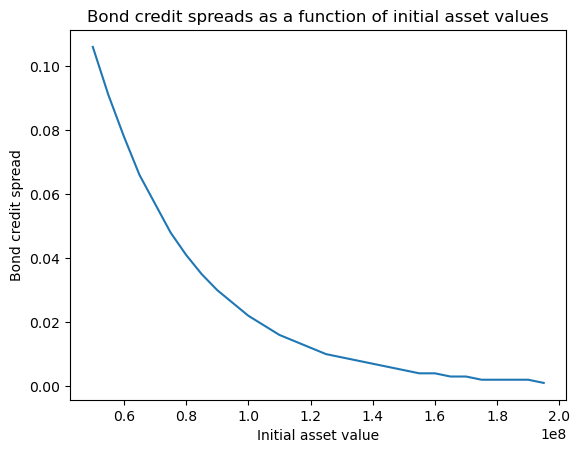

In [117]:
import seaborn as sns

pltlala = sns.lineplot(x=At, y=bond_credit_spreads)
pltlala.set_title('Bond credit spreads as a function of initial asset values')
pltlala.set_xlabel('Initial asset value')
pltlala.set_ylabel('Bond credit spread')

## d. Equity volatility

Compute the Equity Volatility.

What happens to the equity volatility if initial Assets value goes up/down (as of time 0)?

Plot Equity Volatilities of initial Asset values, on a grid from $50 MM to $200 MM in steps of $5 MM.

 

In [118]:
Kt = 100
T = 5
r = 0.04
sigma = 0.2

In [119]:
import math

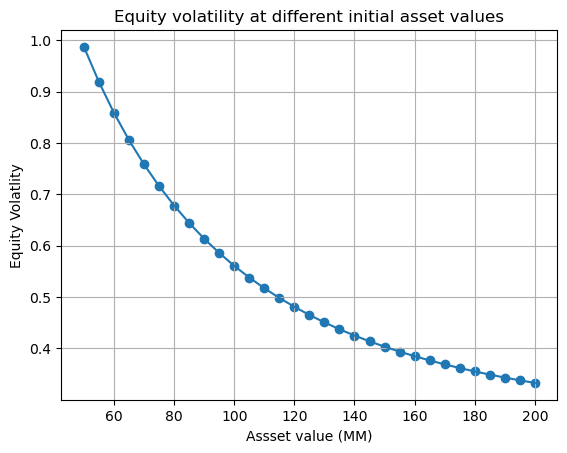

In [120]:
def get_d1_d2(assets, liabilities, r, vol, T):
    leverage = liabilities / assets
    d1 = (-np.log(leverage) + (r + 0.5 * vol**2) * T) / (vol * np.sqrt(T))
    d2 = (-np.log(leverage) + (r - 0.5 * vol**2) * T) / (vol * np.sqrt(T))
    return d1,d2

def merton_equity_volatility(assets, liabilities, r, asset_vol, T):
    
    d1,d2 = get_d1_d2(assets, liabilities, r, asset_vol, T)
    equity_val = equity_FV(assets, liabilities, T, r, asset_vol)
    equity_vol = assets/equity_val * norm.cdf(d1) * asset_vol
    return equity_vol

equity_vols = []

for asset in range(50,205,5):
    vol_e = merton_equity_volatility(asset, Kt, r, sigma, T)
    equity_vols.append(vol_e) 
    
plt.scatter(list(range(50,205,5)),equity_vols)
plt.plot(list(range(50,205,5)),equity_vols)

plt.title('Equity volatility at different initial asset values')
plt.xlabel('Assset value (MM)')
plt.ylabel('Equity Volatlity')
plt.grid(True)
plt.show()

In [121]:

#equity_FV(A_t, K_t, T, r, sigma):
equity_FV(100, 90, 5, 0.04, 0.2)

31.882222387890636